In [35]:
# Initial imports
import os
import datetime
import alpaca_trade_api as tradeapi
import pandas as pd
from alpaca_trade_api import TimeFrame
from pandas.tseries.offsets import DateOffset
from pathlib import Path
from dotenv import load_dotenv
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
import plotly.graph_objects as go
import plotly.express as px
pd.options.plotting.backend = 'plotly'
# Load .env environment variables
load_dotenv()

True

In [36]:
API_KEY = os.getenv("ALPACA_API_KEY")
API_SECRET = os.getenv("ALPACA_SECRET_KEY")
ALPACA_API_BASE_URL = "https://paper-api.alpaca.markets"

In [37]:
# Create a connection to the API 
api = tradeapi.REST("PKWX5HGDE21VGA2ARFSP", "oJmhRhY5PYNWuYBDCJyjf58Tq5gQgbCWtuV33y7b", ALPACA_API_BASE_URL, api_version="v2")

In [38]:
# Add Tesla Data and Dates
tesla = 'TSLA'
start_date = '2016-01-04'
end_date = '2022-10-21'

timeframe = TimeFrame.Day

In [39]:
# Create Tesla DateFrame
tesla_data = api.get_bars(tesla, timeframe, start_date, end_date).df
tesla_data

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2016-01-04 05:00:00+00:00,230.77,231.38,219.00,223.41,6827146,69015,223.588147
2016-01-05 05:00:00+00:00,226.29,226.89,220.00,223.43,3186752,31300,223.139332
2016-01-06 05:00:00+00:00,220.00,220.05,215.98,219.04,3779128,33011,217.791187
2016-01-07 05:00:00+00:00,214.24,218.44,213.67,215.65,3554251,33417,216.042799
2016-01-08 05:00:00+00:00,218.56,220.44,210.77,211.00,3628058,32682,214.595420
...,...,...,...,...,...,...,...
2022-10-17 04:00:00+00:00,210.00,221.86,209.45,219.35,79428814,954631,217.475837
2022-10-18 04:00:00+00:00,229.20,229.82,217.25,220.19,75893644,841838,221.608610
2022-10-19 04:00:00+00:00,219.70,222.93,217.78,222.04,67721429,864644,219.800605


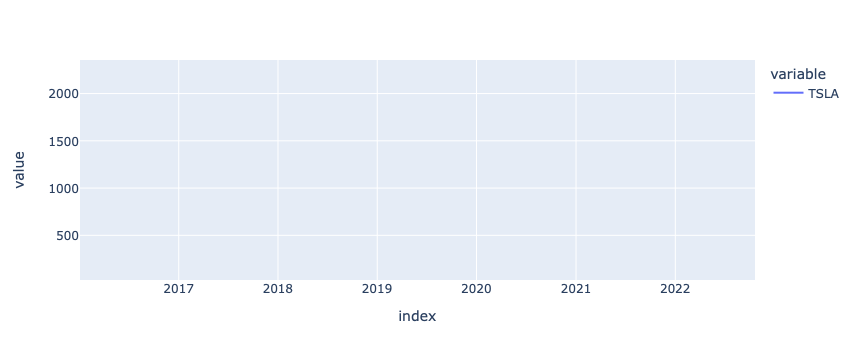

In [40]:
# Plot Tesla Closing Prices
tesla_data = tesla_data.filter(['close'])
tesla_data.rename(columns={'close':'TSLA'}, inplace = True)
tesla_data.index = tesla_data.index.map(lambda timestamp : timestamp.date)
tesla_data.plot()

In [41]:
# Create new column called "Actual Returns" and add percent change to the column.
tesla_data['actual_returns'] = tesla_data['TSLA'].pct_change()
tesla_data

,TSLA,actual_returns
2016-01-04,223.41,NaN
2016-01-05,223.43,0.000090
2016-01-06,219.04,-0.019648
2016-01-07,215.65,-0.015477
2016-01-08,211.00,-0.021563
...,...,...
2022-10-17,219.35,0.070052
2022-10-18,220.19,0.003829
2022-10-19,222.04,0.008402
2022-10-20,207.28,-0.066475


In [42]:
# Create SMA windows
SMA_fast = 5
SMA_slow = 13

In [43]:
# Create two new columns for SMA's, and apply rolling mean
tesla_data['slow_SMA'] = tesla_data['TSLA'].rolling(window=SMA_slow).mean()
tesla_data['fast_SMA'] = tesla_data['TSLA'].rolling(window=SMA_fast).mean()

In [44]:
# Features for X variable are the SMA columns without nulls and shifted one row.
X = tesla_data[['fast_SMA', 'slow_SMA']].shift().dropna().copy()

In [45]:
# Initialize signal column
tesla_data['signal'] = 0.0

In [46]:
# For loop to iterate over each data point in the actual returns column
for i in tesla_data['actual_returns']:
    if i > 0:
        z = True
    else:
        z = False

In [47]:
# locate actual returns greater than or equal to 0
tesla_data.loc[(tesla_data['actual_returns'] >= 0), 'signal'] = 1

In [48]:
# locate actual returns less than 0 
tesla_data.loc[(tesla_data['actual_returns'] < 0), 'signal'] = -1

In [49]:
# Make a copy of signal column for y values
y = tesla_data['signal'].copy()

In [50]:
# Specify the training datas beginning point
training_begin = X.index.min()
print(training_begin)

2016-01-22


In [51]:
# Specify the training datas end point. Using DateOffset, to easily add 6 years and close end point.
training_end = X.index.min() + DateOffset(months=72)

In [52]:
# Identify data to use for training
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

/opt/conda/lib/python3.7/site-packages/pandas/core/algorithms.py:1601: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [53]:
# Identify the data used for testing
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

In [54]:
# Initiate StandardScaler Model, Fit, Transform
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [55]:
# Initiate SVC model from svm package, fit and predict using trained data.
svm_model = svm.SVC()
svm_model = svm_model.fit(X_train_scaled, y_train)
training_signal_predictions = svm_model.predict(X_train_scaled)
training_signal_predictions

array([1., 1., 1., ..., 1., 1., 1.])

In [56]:
# Print the classification report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)


              precision    recall  f1-score   support

        -1.0       1.00      0.00      0.01       719
         1.0       0.53      1.00      0.69       793

    accuracy                           0.53      1512
   macro avg       0.76      0.50      0.35      1512
weighted avg       0.75      0.53      0.36      1512



In [57]:
# Predict model using scaled testing data
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [58]:
# Print testing data classification report
testing_report = classification_report(y_test, testing_signal_predictions)
print(testing_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00        92
         1.0       0.51      1.00      0.68        97

    accuracy                           0.51       189
   macro avg       0.26      0.50      0.34       189
weighted avg       0.26      0.51      0.35       189



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [59]:
# Create a Dataframe using predicted data
predictions_data = pd.DataFrame(index=X_test.index)

# Add two new columns to the DateFrame called predicted signals and actual returns
predictions_data['predicted_signals'] = testing_signal_predictions
predictions_data['actual_returns'] = tesla_data['actual_returns']

# Add third column that is the sum of the two previously made columns
predictions_data['trading_algorithm_returns'] = (predictions_data['actual_returns'] * predictions_data['predicted_signals'])


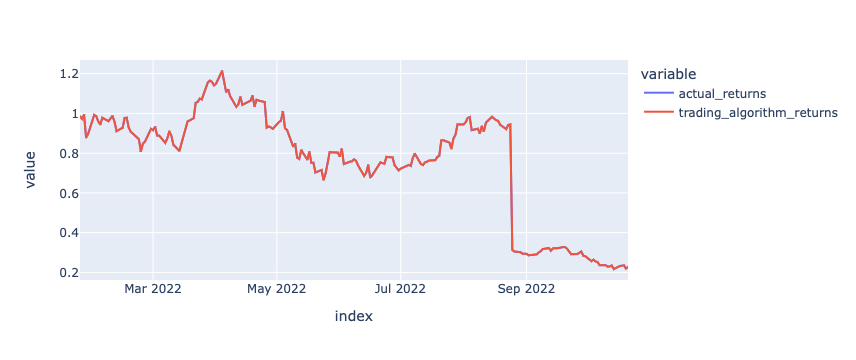

In [60]:
# Plot Teslas actual returns in culmination with the predictied algorthim returns.
(1 + predictions_data[['actual_returns', 'trading_algorithm_returns']]).cumprod().plot()

In [61]:
# If else statement communicating to the bot whether to buy or sell Tesla stock.
if z == True:
    orderSide = 'buy'
else:
    orderSide = 'sell'

In [62]:
# Gather 5 shares of Tesla
ticker = 'TSLA'
number_of_shares = 5

In [63]:
# Make API call
prices = api.get_bars(ticker, '1Min').df

# Reorganize the DataFrame
prices = pd.concat([prices], axis=1, keys=['TSLA'])

# Get final closing price
limit_amount = prices['TSLA']['close'][-1]

KeyError: 'TSLA'

In [64]:
# Submit order
api.submit_order(
    symbol='TSLA',
    qty=number_of_shares,
    side=orderSide,
    time_in_force='gtc',
    type='limit',
    limit_price=limit_amount)

NameError: name 'limit_amount' is not defined

In [ ]:
#tesla_data = tesla_data.dropna(inplace=True)

In [ ]:
#tesla_data.plot(y=['TSLA', 'slow_SMA', 'fast_SMA'])